Deep learning Image Deblurring <br> 


In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

According to the above code, the dataset of cifar10 has been used, the gussian noise has beeb applied on the dataset, and the dataset function is returning both the train and test datasets. We can extract the x_test, y_test, x_train, y_train:

In [2]:
(x_train, y_train), (x_test, y_test) = getDataset()

Let's check the shape of our training and test set shape:

In [3]:
print ('The shape of the train set is:', x_train.shape)
print ('The shape of the test set is:', x_test.shape)

The shape of the train set is: (50000, 32, 32, 3)
The shape of the test set is: (10000, 32, 32, 3)


We see that we have 50000 images in our train set and 10000 images in test set. The size of each image is 32*32 and it has 3 channels.

Let's see the range of the pixels:

In [4]:
print("pixel range is [{},{}]".format(np.min(x_train),np.max(x_train)))

pixel range is [-0.08780306254444549,1.0919241498354855]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


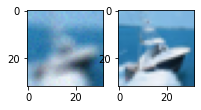

In [5]:
plt.figure (figsize = (3,3))
idx = 8
ax = plt.subplot(1, 2, 1)
plt.imshow(x_train[idx])
ax = plt.subplot(1, 2, 2)
plt.imshow(y_train[idx])
plt.show()

In [6]:
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, Dense, Flatten, Layer, Conv2DTranspose, Activation, Subtract, BatchNormalization, Multiply
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Add, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

## Building the model

First, I am going to use an autoencoder to build a deep neural network to deblurr the nosiy images. <br>
The autoencoder includes 3 convolutional layers for encloding and 3 convultional layers for decoding.

The autoencoder is used for denoising of the images. The autoencoder uses the noisy images as input and by encoding and then decoding the images, tries to make the output of the model as close as possible to the original images (denoised ones).

In [7]:
Input_img = Input(shape=(32, 32, 3))  
    
# encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D((2, 2))(x2)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

model = Model(Input_img, decoded)


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        147520    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        9232      
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        9280      
                                                             

Now, I will compile my model with 'adam' optimizer and 'mean_squared_error' as the loss function.

In [9]:
model.compile(optimizer='adam',loss='mean_squared_error')

I will use the test set as my validation data and I will fit the model on the train set.

In [10]:
base_1 = model.fit(x_train,y_train, shuffle=True, epochs=15, batch_size=32,validation_data=(x_test,y_test))

Epoch 1/15
1563/1563 [==============================] - 48s 24ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 2/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 3/15
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/15
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/15
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/15
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/15
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/15
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/15
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/15
1563/1563 [==============================] - 37s 24m

The model is showing a  good performance from value of loss point of view on both validation and training set.

In [11]:
output_imgs = model.predict(x_test)

In [12]:
np.mean(np.square(y_test-output_imgs))

0.002713819538411077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


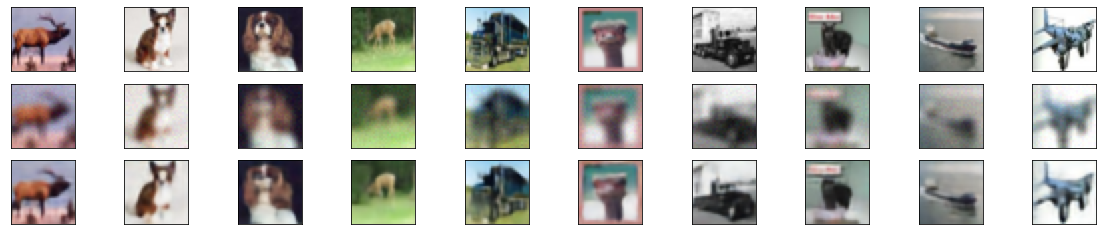

In [13]:
import matplotlib.pyplot as plt
import cv2

n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display target
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_test[idx].reshape(32, 32, 3))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, n, i + 1+n)
    plt.imshow(x_test[idx].reshape(32, 32, 3))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(output_imgs[idx].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As observed in the images above, the model is successful in deblurring the input images, but compared to the target image, there is still place for improvement.

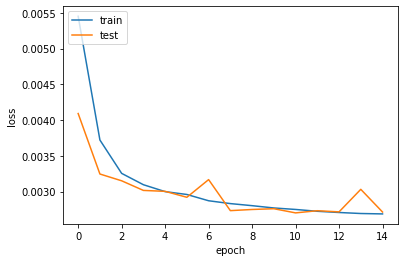

In [14]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#plot_history(base_history,['accuracy','val_accuracy'])
plot_history(base_1,['loss','val_loss'])

There is another model used for denoising of images proposed by the paper: "Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising". This model which is called DnCNN, uses convolutional layers to predict the noise and then by subtracting the predicted noise from the input images, the denoised image will be obtained. The model is using a feedforward denoisng convolutional neural network with batch normalization. 
I have implemented a simple version of the aforementioned model here below:

In [15]:
def DnCNN():

    input = Input(shape=(32,32,3),)

    x = Conv2D(64,kernel_size= (3,3), padding='same',)(input)

    x = Activation('relu',name='act_l1')(x)

    for i in range(17):

        x = Conv2D(64, kernel_size=(3,3), padding='same',)(x)

        x = BatchNormalization(axis=-1,)(x)

        x = Activation('relu',)(x)

    x = Conv2D(3, kernel_size=(3,3), padding='same',)(x)

    x = Subtract()([input, x])

    model = Model(input,x)

    return model

In [16]:
model_2 = DnCNN()
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 act_l1 (Activation)            (None, 32, 32, 64)   0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 64)   36928       ['act_l1[0][0]']                 
                                                                                            

In [17]:
model_2.compile(optimizer='adam',loss='mean_squared_error')

In [19]:
base_2 = model_2.fit(x_train,y_train, shuffle=True, epochs=15, batch_size=32,validation_data=(x_test,y_test))

Epoch 1/15
1563/1563 [==============================] - 71s 44ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 2/15
1563/1563 [==============================] - 68s 43ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 3/15
1563/1563 [==============================] - 68s 43ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/15
1563/1563 [==============================] - 69s 44ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/15
1563/1563 [==============================] - 69s 44ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/15
1563/1563 [==============================] - 68s 43ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/15
1563/1563 [==============================] - 69s 44ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 8/15
1563/1563 [==============================] - 68s 44ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/15
1563/1563 [==============================] - 68s 44ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/15
1563/1563 [==============================] - 68s 44m

In [20]:
output_imgs_2 = model_2.predict(x_test)

In [21]:
np.mean(np.square(y_test-output_imgs_2))

0.0024716519932981565

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


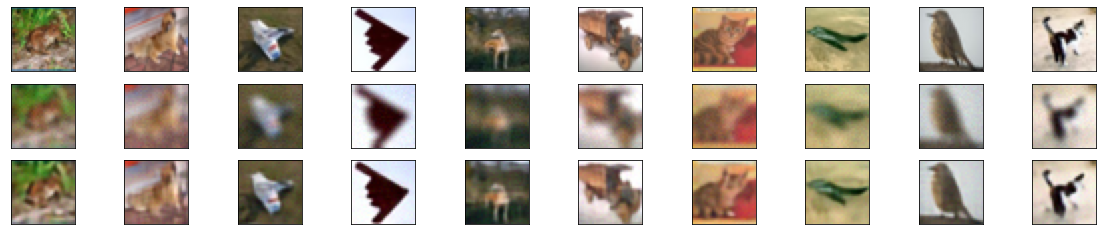

In [22]:
n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display target
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_test[idx].reshape(32, 32, 3))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, n, i + 1+n)
    plt.imshow(x_test[idx].reshape(32, 32, 3))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(output_imgs_2[idx].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The validation loss of the second model (DnCNN) is showing a better result than the first model. But both models seems to be acceptable to predict the deblurres images.


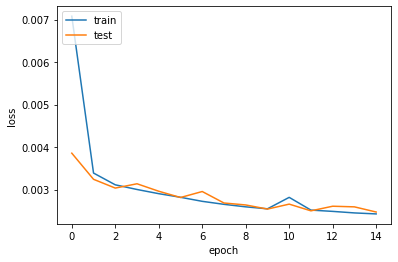

In [23]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#plot_history(base_history,['accuracy','val_accuracy'])
plot_history(base_2,['loss','val_loss'])

In [24]:
model.save('base_1')

INFO:tensorflow:Assets written to: base_1/assets


In [25]:
model.save ('base_2')

INFO:tensorflow:Assets written to: base_2/assets


In [26]:
model.save_weights("base_1.hdf5")

In [27]:
model.save_weights("base_2.hdf5")